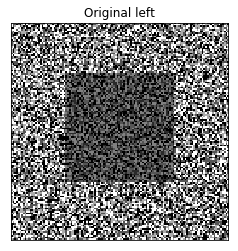

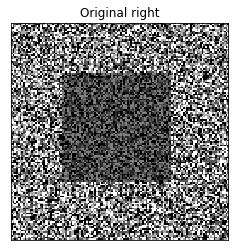

In [1]:
import cv2
import numpy as np
import sys
from matplotlib import pyplot as plt
from numba import jit



left = cv2.imread('Data\\leftTest.png',0)
right = cv2.imread('Data\\rightTest.png',0)


plt.imshow(left,cmap='gray')
plt.title('Original left'), plt.xticks([]), plt.yticks([])
plt.show()


plt.imshow(right,cmap='gray')
plt.title('Original right'), plt.xticks([]), plt.yticks([])
plt.show()

## 1 -

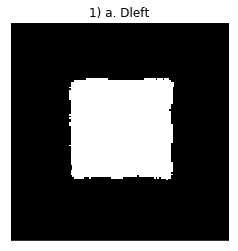

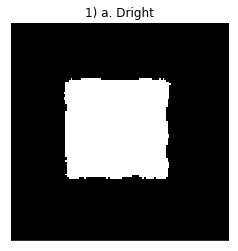

(array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]))

In [2]:
@jit
def SSD(template,other,i,j,offset,winSizeHalf):
    result=0
    for i2 in range(-winSizeHalf,winSizeHalf):
        for j2 in range(-winSizeHalf,winSizeHalf):
            result+=(template[j+j2,i+i2]-other[j+j2,i+i2-offset])**2
    return result

@jit
def stereoLeftToRight(left,right,winSize,dmin,dmax):    
    height, width = left.shape   
    winSizeHalf=int(winSize/2)
    corr=255/dmax    
    dTab=np.zeros((height,width)) 
    for i in range(winSizeHalf,width-winSizeHalf):
        print(str((i+1-winSizeHalf)*100/(width-winSizeHalf))+"% of an image", end="\r")
        for j in range(winSizeHalf,height-winSizeHalf):
            disp=[]
            for d in range(dmin,dmax):
                disp.append(SSD(left,right,i,j,d,winSizeHalf))
            if(disp):
                dTab[j,i]=(np.argmin(disp[:])+dmin)*corr
            else:
                print("Error, nothing in range")
    return dTab

@jit
def stereo(left,right,winSize,dmin,dmax,legend1,legend2):
    dTab=stereoLeftToRight(left,right,winSize,dmin,dmax)
    imgplot = plt.imshow(dTab,cmap='gray')
    plt.title(legend1), plt.xticks([]), plt.yticks([])
    plt.show()
    #to do the other way around we used the same algorithm but flip the input
    dTab2=stereoLeftToRight(cv2.flip(right, flipCode=1),cv2.flip(left, flipCode=1),winSize,dmin,dmax)
    dTab2=cv2.flip(dTab2, flipCode=1)# the result is flipped as well
    imgplot = plt.imshow(dTab2,cmap='gray')
    plt.title(legend2), plt.xticks([]), plt.yticks([])
    plt.show()
    return dTab,dTab2

dmin=0 #strict bound
dmax=4 #soft bound  
stereo(left,right,10,dmin,dmax,'1) a. Dleft','1) a. Dright')  

## 2 -

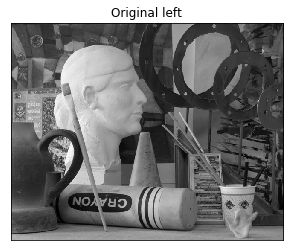

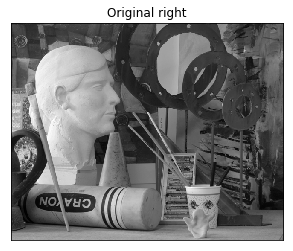

In [3]:
left = cv2.imread('Data\\proj2-pair1-L.png',0)
right = cv2.imread('Data\\proj2-pair1-R.png',0)


plt.imshow(left,cmap='gray')
plt.title('Original left'), plt.xticks([]), plt.yticks([])
plt.show()


plt.imshow(right,cmap='gray')
plt.title('Original right'), plt.xticks([]), plt.yticks([])
plt.show()

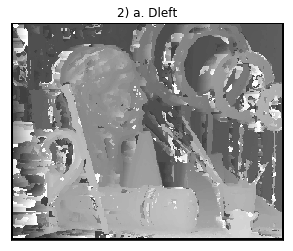

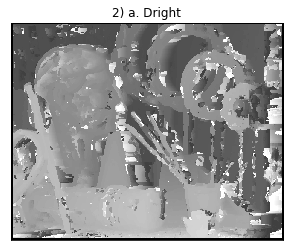

In [4]:
dmin=30
dmax=120    
dTab,dTab2=stereo(left,right,8,dmin,dmax,'2) a. Dleft','2) a. Dright')  

### Result comparaison:
Some differences are noticeable, mainly on the extremity of the image (left for Dleft, right for Drigh). This is due to the fact that there are no points to match with for those pixels. Some more errors are noticeable, due to less textured areas.

## 3 -

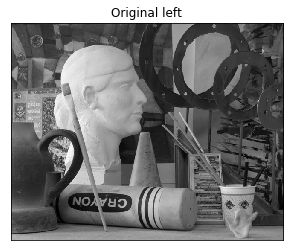

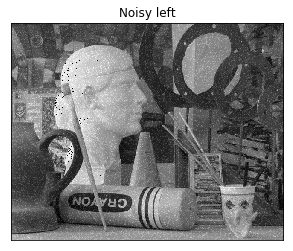

In [5]:
left = cv2.imread('Data\\proj2-pair1-L.png',0)




height, width = left.shape   
im = np.zeros((height,width), np.uint8)
cv2.randn(im,(0),(20))
leftNoise=left+im


plt.imshow(left,cmap='gray')
plt.title('Original left'), plt.xticks([]), plt.yticks([])
plt.show()


plt.imshow(leftNoise,cmap='gray')
plt.title('Noisy left'), plt.xticks([]), plt.yticks([])
plt.show()

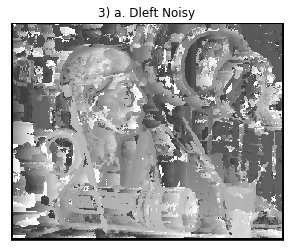

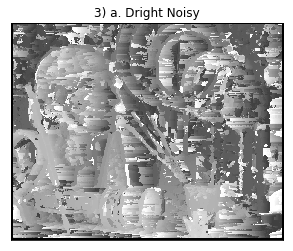

In [6]:
  
dTab,dTab2=stereo(leftNoise,right,8,dmin,dmax,'3) a. Dleft Noisy','3) a. Dright Noisy') 

The loss is quite noticeable here, we see lots of artefacts due to noise. A gaussian smoothin might help.

### 3 - b Contrast

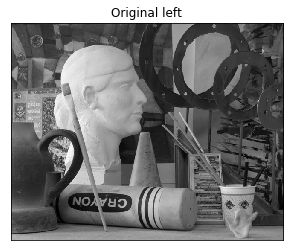

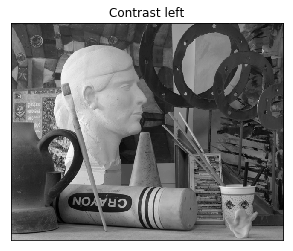

In [7]:
left = cv2.imread('Data\\proj2-pair1-L.png',0)
leftContrast=left*1.1


plt.imshow(left,cmap='gray')
plt.title('Original left'), plt.xticks([]), plt.yticks([])
plt.show()


plt.imshow(leftContrast,cmap='gray')
plt.title('Contrast left'), plt.xticks([]), plt.yticks([])
plt.show()

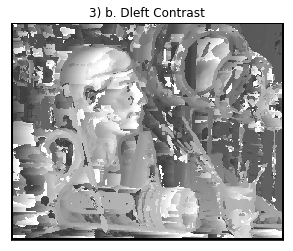

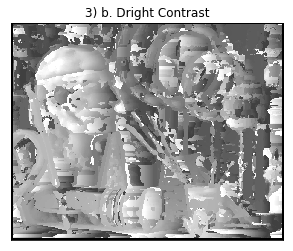

In [8]:
 
dTab,dTab2=stereo(leftContrast,right,8,dmin,dmax,'3) b. Dleft Contrast','3) b. Dright Contrast') 

Here we see some artefacts, but it does not look as bas as on Gaussian noise. The biggest impact is on big surfaces of umiform texture

## 4 - a

In [9]:
@jit
def stereoNormed(source, target, winSize, lefttoright):
    rows, cols = source.shape
    dTab = np.zeros([rows, cols], dtype="uint8")
    source = np.matrix(source, dtype = "uint32")
    target = np.matrix(target, dtype = "uint32")
    flooredWin=np.floor(winSize/2.0)
    ceiledWin=np.ceil(winSize/2.0)
    for i in range(int(flooredWin), int(rows - flooredWin)):
        minI = int(i-flooredWin)
        maxI = int(i+ceiledWin)
        print(str(i*100/ int(rows - flooredWin))+"% of an image", end="\r")
    
        for j in range(int(flooredWin), int(cols - flooredWin)):

            minJ = int(j-flooredWin)
            maxJ = int(j+ceiledWin)
            targetWin = target[minI:maxI,:]
            srcWin = source[minI:maxI, minJ:maxJ]
            srcWin = np.asarray(srcWin,dtype ="float32")
            targetWin = np.asarray(targetWin,dtype = "float32")
            if lefttoright:
                direction = 1
            else:
                direction = -1

            matching = cv2.matchTemplate(targetWin, srcWin, cv2.TM_CCOEFF_NORMED)
            maxInd = cv2.minMaxLoc(matching)[3]
            dTab[i, j] = direction *(maxInd[0]- j)
    dTab = cv2.normalize(dTab, dTab, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    return dTab


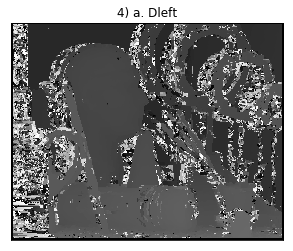

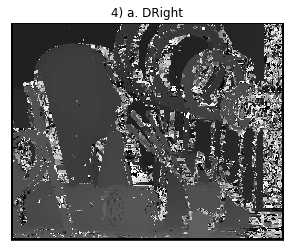

In [10]:
left = cv2.imread('Data\\proj2-pair1-L.png',0)
right = cv2.imread('Data\\proj2-pair1-R.png',0)


d1 = stereoNormed(left, right,9,False)  
plt.imshow(d1, cmap="gray")
plt.title('4) a. Dleft'), plt.xticks([]), plt.yticks([])
plt.show()
    
d2 = stereoNormed(right, left,9,True) 
plt.imshow(d2, cmap="gray")
plt.title('4) a. DRight'), plt.xticks([]), plt.yticks([])
plt.show()


This method seems to give better estimates of the similarity between two windows, as the result is close to ground truth

## 4 - b Gaussian

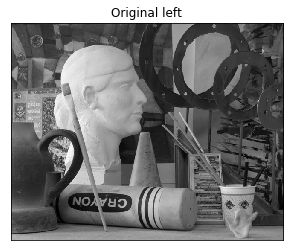

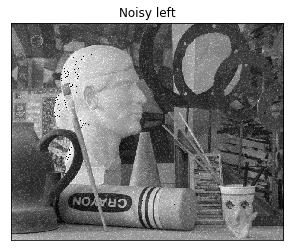

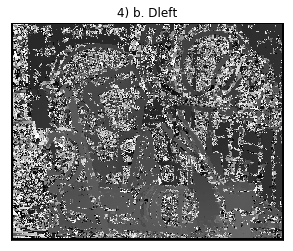

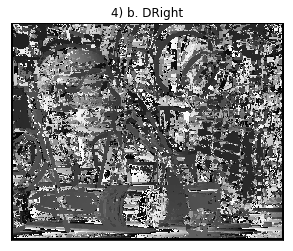

In [11]:
left = cv2.imread('Data\\proj2-pair1-L.png',0)




height, width = left.shape   
im = np.zeros((height,width), np.uint8)
cv2.randn(im,(0),(20))
leftNoise=left+im


plt.imshow(left,cmap='gray')
plt.title('Original left'), plt.xticks([]), plt.yticks([])
plt.show()


plt.imshow(leftNoise,cmap='gray')
plt.title('Noisy left'), plt.xticks([]), plt.yticks([])
plt.show()

d1 = stereoNormed(leftNoise, right,9,False)  
plt.imshow(d1, cmap="gray")
plt.title('4) b. Dleft'), plt.xticks([]), plt.yticks([])
plt.show()
    
d2 = stereoNormed(right, leftNoise,9,True) 
plt.imshow(d2, cmap="gray")
plt.title('4) b. DRight'), plt.xticks([]), plt.yticks([])
plt.show()


We see that the gaussian noise as a much stronger impact on this metric, as the two pictures are completly full of noise

## 4 - b Contrast

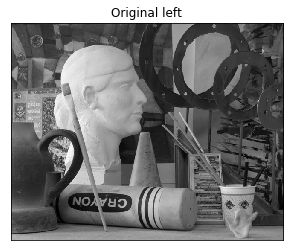

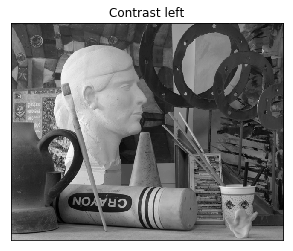

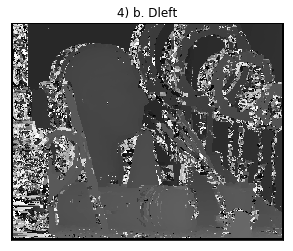

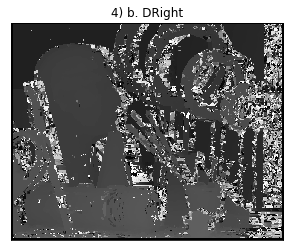

In [12]:
left = cv2.imread('Data\\proj2-pair1-L.png',0)
leftContrast=left*1.1


plt.imshow(left,cmap='gray')
plt.title('Original left'), plt.xticks([]), plt.yticks([])
plt.show()


plt.imshow(leftContrast,cmap='gray')
plt.title('Contrast left'), plt.xticks([]), plt.yticks([])
plt.show()

d1 = stereoNormed(leftContrast, right,9,False)  
plt.imshow(d1, cmap="gray")
plt.title('4) b. Dleft'), plt.xticks([]), plt.yticks([])
plt.show()
    
d2 = stereoNormed(right, leftContrast,9,True) 
plt.imshow(d2, cmap="gray")
plt.title('4) b. DRight'), plt.xticks([]), plt.yticks([])
plt.show()


We notice that a change in contrast does not have a stong impact on this metric, due to the fact that we see images as vectors when using it.

## 5 -

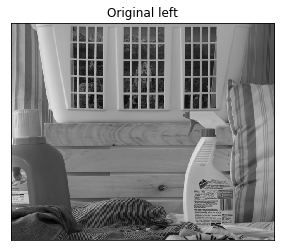

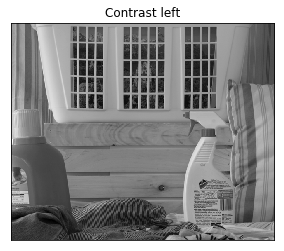

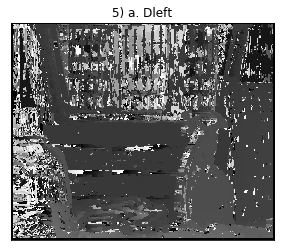

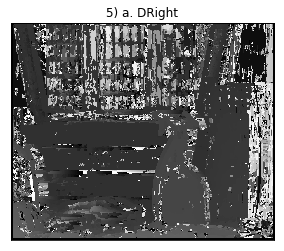

In [13]:
left = cv2.imread('Data\\proj2-pair2-L.png',0)
right = cv2.imread('Data\\proj2-pair2-R.png',0)
leftContrast=left*1.1


plt.imshow(left,cmap='gray')
plt.title('Original left'), plt.xticks([]), plt.yticks([])
plt.show()


plt.imshow(leftContrast,cmap='gray')
plt.title('Contrast left'), plt.xticks([]), plt.yticks([])
plt.show()

d1 = stereoNormed(leftContrast, right,9,False)  
plt.imshow(d1, cmap="gray")
plt.title('5) a. Dleft'), plt.xticks([]), plt.yticks([])
plt.show()
    
d2 = stereoNormed(right, leftContrast,9,True) 
plt.imshow(d2, cmap="gray")
plt.title('5) a. DRight'), plt.xticks([]), plt.yticks([])
plt.show()


It seems that there is not much to do to improve the quality of the result here. Using an increased contrast seems to have a good effect, but it could just be  luck.